In [4]:
# Import Dependencies
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import requests
import json
import hvplot.pandas
from scipy.stats import linregress
import scipy.stats as st

# Import the API key
from config import api_key

In [5]:
# Read in our csv file with city info and put it into a dataframe
file_path = Path("../Resources/worldcities_2023.csv")
city_df = pd.read_csv(file_path)

city_df

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37732000.0,1392685764
1,Jakarta,Jakarta,-6.1750,106.8275,Indonesia,ID,IDN,Jakarta,primary,33756000.0,1360771077
2,Delhi,Delhi,28.6100,77.2300,India,IN,IND,Delhi,admin,32226000.0,1356872604
3,Guangzhou,Guangzhou,23.1300,113.2600,China,CN,CHN,Guangdong,admin,26940000.0,1156237133
4,Mumbai,Mumbai,19.0761,72.8775,India,IN,IND,Mahārāshtra,admin,24973000.0,1356226629
...,...,...,...,...,...,...,...,...,...,...,...
44686,Numto,Numto,63.6667,71.3333,Russia,RU,RUS,Khanty-Mansiyskiy Avtonomnyy Okrug-Yugra,NaN,10.0,1643985006
44687,Nord,Nord,81.7166,-17.8000,Greenland,GL,GRL,NaN,NaN,10.0,1304217709
44688,Timmiarmiut,Timmiarmiut,62.5333,-42.2167,Greenland,GL,GRL,Kujalleq,NaN,10.0,1304206491
44689,San Rafael,San Rafael,-16.7795,-60.6799,Bolivia,BO,BOL,Santa Cruz,NaN,NaN,1068007388


In [6]:
# Filter only for cities in the US with a population of 100,000 residents or more
usa_df = city_df.loc[(city_df["country"] == "United States") & (city_df["population"] >= 100000)]

# Change population column from a float to integer and drop any rows with missing information
usa_df = usa_df.rename(columns={"admin_name": "state"})
usa_df["population"] = usa_df["population"].astype("int64")
usa_df.dropna(how="any")

usa_df

,city,city_ascii,lat,lng,country,iso2,iso3,state,capital,population,id
11,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,18972871,1840034016
33,Los Angeles,Los Angeles,34.1141,-118.4068,United States,US,USA,California,NaN,12121244,1840020491
55,Chicago,Chicago,41.8375,-87.6866,United States,US,USA,Illinois,NaN,8595181,1840000494
100,Miami,Miami,25.7840,-80.2101,United States,US,USA,Florida,NaN,5711945,1840015149
104,Dallas,Dallas,32.7935,-96.7667,United States,US,USA,Texas,NaN,5668165,1840019440
...,...,...,...,...,...,...,...,...,...,...,...
5953,Lee's Summit,Lee's Summit,38.9171,-94.3816,United States,US,USA,Missouri,NaN,100772,1840032155
5962,Quincy,Quincy,42.2506,-71.0187,United States,US,USA,Massachusetts,NaN,100544,1840000461
5974,San Angelo,San Angelo,31.4424,-100.4504,United States,US,USA,Texas,NaN,100330,1840022146
5976,Lynn,Lynn,42.4781,-70.9664,United States,US,USA,Massachusetts,NaN,100233,1840000409


In [7]:
# Get a statistical overview of our columns
usa_df.describe()

,lat,lng,population,id
count,476.000000,476.000000,4.760000e+02,4.760000e+02
mean,36.923922,-95.990705,5.433168e+05,1.840016e+09
std,5.356942,17.686915,1.335352e+06,1.227606e+04
min,21.329400,-157.846000,1.002020e+05,1.840000e+09
25%,33.469975,-115.338925,1.300660e+05,1.840007e+09
50%,37.090450,-92.354950,1.987120e+05,1.840018e+09
75%,40.815425,-81.142600,3.820475e+05,1.840021e+09
max,61.150800,-70.271500,1.897287e+07,1.840088e+09


In [8]:
# Ensure that all columns have the proper data-types
usa_df.dtypes

city           object
city_ascii     object
lat           float64
lng           float64
country        object
iso2           object
iso3           object
state          object
capital        object
population      int64
id              int64
dtype: object

In [9]:
# Add new Air Quality Index Level columns for each city in dataframe
usa_df["AQI"] = " "
usa_df["CO"] = " "
usa_df["NO"] = " "
usa_df["NO2"] = " "
usa_df["O3"] = " "
usa_df["SO2"] = " "
usa_df["PM2.5"] = " "
usa_df["PM10"] = " "
usa_df["NH3"] = " "

usa_df

,city,city_ascii,lat,lng,country,iso2,iso3,state,capital,population,id,AQI,CO,NO,NO2,O3,SO2,PM2.5,PM10,NH3
11,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,18972871,1840034016,,,,,,,,,
33,Los Angeles,Los Angeles,34.1141,-118.4068,United States,US,USA,California,NaN,12121244,1840020491,,,,,,,,,
55,Chicago,Chicago,41.8375,-87.6866,United States,US,USA,Illinois,NaN,8595181,1840000494,,,,,,,,,
100,Miami,Miami,25.7840,-80.2101,United States,US,USA,Florida,NaN,5711945,1840015149,,,,,,,,,
104,Dallas,Dallas,32.7935,-96.7667,United States,US,USA,Texas,NaN,5668165,1840019440,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5953,Lee's Summit,Lee's Summit,38.9171,-94.3816,United States,US,USA,Missouri,NaN,100772,1840032155,,,,,,,,,
5962,Quincy,Quincy,42.2506,-71.0187,United States,US,USA,Massachusetts,NaN,100544,1840000461,,,,,,,,,
5974,San Angelo,San Angelo,31.4424,-100.4504,United States,US,USA,Texas,NaN,100330,1840022146,,,,,,,,,
5976,Lynn,Lynn,42.4781,-70.9664,United States,US,USA,Massachusetts,NaN,100233,1840000409,,,,,,,,,


In [11]:
# Set base URL and params to search for current air pollution data
base_url = "http://api.openweathermap.org/data/2.5/air_pollution?"

params = {"appid":api_key}

# Print a message to follow up the air pollution search
print("Starting city air pollution details search:")

# Iterate through the usa_df dataframe
for index, row in usa_df.iterrows():
    
    # Get city name, latitude, and longitude values for each row in dataframe
    city = row["city"]
    lat = row["lat"]
    lng = row["lng"]
    
    # Add the current city's latitude and longitude to the params dictionary
    params["lat"] = lat
    params["lon"] = lng
    
    # Make an API request using params dictionary and store it into a json
    response = requests.get(base_url, params=params)
    data = response.json()
    
    # Drill down to get the values we are looking for in the json and store those values in our dataframe
    try:
        usa_df.loc[index, "AQI"] = data["list"][0]["main"]["aqi"]
        usa_df.loc[index, "CO"] = data["list"][0]["components"]["co"]
        usa_df.loc[index, "NO"] = data["list"][0]["components"]["no"]
        usa_df.loc[index, "NO2"] = data["list"][0]["components"]["no2"]
        usa_df.loc[index, "O3"] = data["list"][0]["components"]["o3"]
        usa_df.loc[index, "SO2"] = data["list"][0]["components"]["so2"]
        usa_df.loc[index, "PM2.5"] = data["list"][0]["components"]["pm2_5"]
        usa_df.loc[index, "PM10"] = data["list"][0]["components"]["pm10"]
        usa_df.loc[index, "NH3"] = data["list"][0]["components"]["nh3"]
        
        
    except Exception as e:
        # If city is not found, log the error.
        print(f"{e.args} not found for {usa_df.loc[index, 'city']}")
        
    print(f"Appending results for {city}")

Starting city air pollution details search:
Appending results for New York
Appending results for Los Angeles
Appending results for Chicago
Appending results for Miami
Appending results for Dallas
Appending results for Houston
Appending results for Philadelphia
Appending results for Atlanta
Appending results for Washington
Appending results for Boston
Appending results for Phoenix
Appending results for Detroit
Appending results for Seattle
Appending results for San Francisco
Appending results for San Diego
Appending results for Minneapolis
Appending results for Brooklyn
Appending results for Tampa
Appending results for Denver
Appending results for Queens
Appending results for Baltimore
Appending results for Las Vegas
Appending results for St. Louis
Appending results for Portland
Appending results for Riverside
Appending results for Orlando
Appending results for Sacramento
Appending results for San Antonio
Appending results for San Jose
Appending results for Pittsburgh
Appending results 

#####  Air Quality Index. Possible values: 1, 2, 3, 4, 5. Where 1 = Good, 2 = Fair, 3 = Moderate, 4 = Poor, 5 = Very Poor.

In [128]:
# Preview the updated dataframe and sort the results by AQI in descending order
usa_df.sort_values(by=["AQI", "PM2.5"], ascending=False).head(20)

,city,city_ascii,lat,lng,country,iso2,iso3,state,capital,population,id,AQI,CO,NO,NO2,O3,SO2,PM2.5,PM10,NH3
535,Bronx,Bronx,40.8501,-73.8662,United States,US,USA,New York,NaN,1472654,1840033999,5,480.0,0.0,19.0,377.0,21.0,70.0,74.0,2.0
3159,Yonkers,Yonkers,40.9466,-73.8673,United States,US,USA,New York,NaN,209730,1840003478,5,480.0,0.0,19.0,377.0,21.0,70.0,74.0,2.0
2299,Newark,Newark,40.7245,-74.1725,United States,US,USA,New Jersey,NaN,306247,1840002791,5,453.0,0.0,24.0,331.0,15.0,62.0,65.0,1.0
2422,Jersey City,Jersey City,40.7184,-74.0686,United States,US,USA,New Jersey,NaN,287146,1840003600,5,453.0,0.0,24.0,331.0,15.0,62.0,65.0,1.0
4572,Elizabeth,Elizabeth,40.6658,-74.1913,United States,US,USA,New Jersey,NaN,135772,1840003613,5,453.0,0.0,24.0,331.0,15.0,62.0,65.0,1.0
11,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,18972871,1840034016,5,473.0,0.0,28.0,303.0,19.0,55.0,58.0,2.0
291,Brooklyn,Brooklyn,40.6501,-73.9496,United States,US,USA,New York,NaN,2736074,1840034030,5,473.0,0.0,28.0,303.0,19.0,55.0,58.0,2.0
469,Manhattan,Manhattan,40.7834,-73.9662,United States,US,USA,New York,NaN,1694263,1840034000,5,473.0,0.0,28.0,303.0,19.0,55.0,58.0,2.0
352,Queens,Queens,40.7498,-73.7976,United States,US,USA,New York,NaN,2405464,1840034002,5,420.0,0.0,19.0,274.0,12.0,46.0,49.0,1.0
1080,Hempstead,Hempstead,40.6629,-73.6089,United States,US,USA,New York,NaN,791018,1840005293,5,420.0,0.0,19.0,274.0,12.0,46.0,49.0,1.0


In [114]:
# Convert new columns to correct data types

usa_df = usa_df.astype({"AQI": "int64", 
                        "CO": "float64",
                        "NO": "float64",
                        "NO2": "float64",
                        "O3":"float64",
                        "SO2": "float64",
                        "PM2.5":"float64",
                        "PM10":"float64",
                        "NH3": "float64"})

usa_df.dtypes

city           object
city_ascii     object
lat           float64
lng           float64
country        object
iso2           object
iso3           object
state          object
capital        object
population      int64
id              int64
AQI             int64
CO            float64
NO            float64
NO2           float64
O3            float64
SO2           float64
PM2.5         float64
PM10          float64
NH3           float64
dtype: object

In [86]:
# Check which states in the US show the poorest AQI in descending order
state_df = usa_df.groupby("state")["AQI"].mean()
state_df = state_df.sort_values(ascending=False)
state_df.head()

state
New Jersey    4.444444
New York      3.791667
California    3.636364
Texas         3.044444
Nevada             3.0
Name: AQI, dtype: Float64

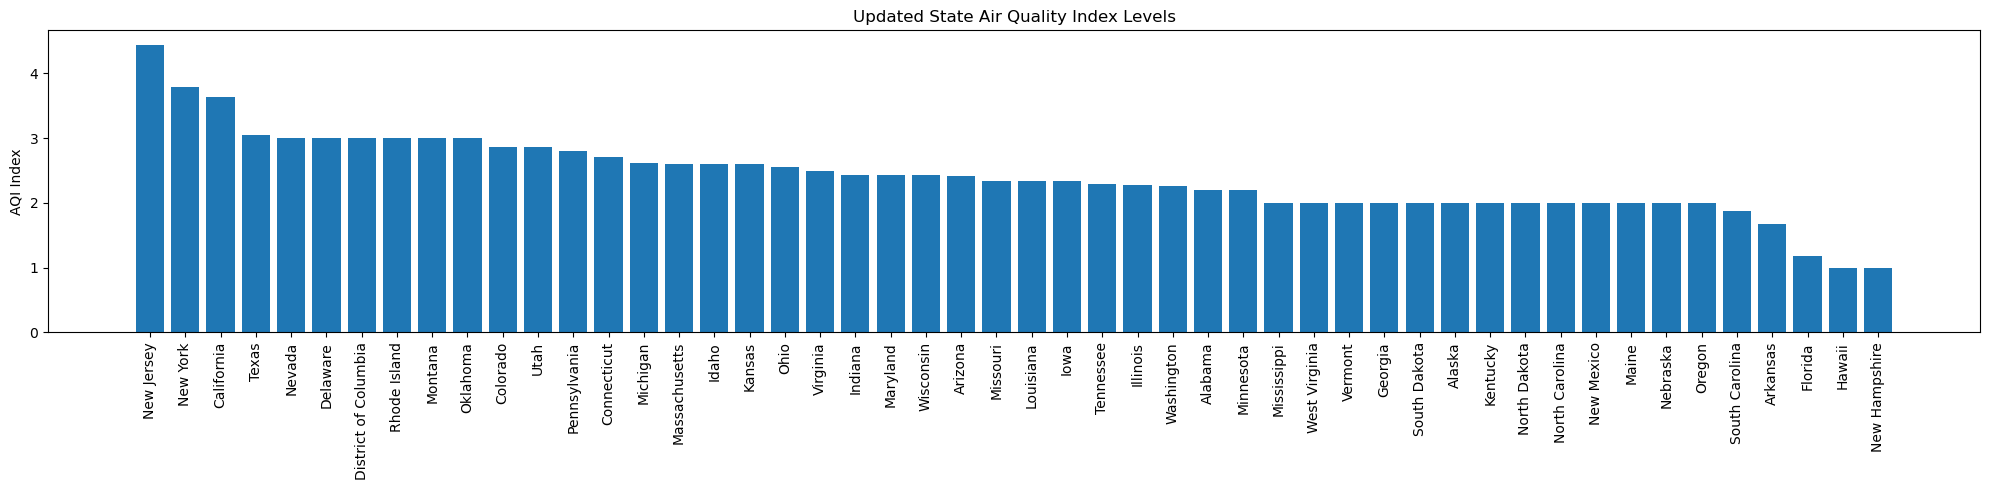

In [45]:
# Show all the states in the US by AQI in descending order. 
plt.figure(figsize=(20,5))
plt.bar(state_df.index, state_df.values)


# Add labels and graph properties
plt.title("Updated State Air Quality Index Levels")
plt.ylabel("AQI Index")
plt.xticks(rotation = 90)
plt.tight_layout()

# Save the figure
plt.savefig("output_data/Fig1.png")

# Show plot
plt.show()

In [31]:
# Since New Jersey had the highest (poorest) AQI score, check which cities contribute the most to the score.
usa_df.loc[usa_df["state"] == "New Jersey"].head(10)

,city,city_ascii,lat,lng,country,iso2,iso3,state,capital,population,id,AQI,CO,NO,NO2,O3,SO2,PM2.5,PM10,NH3
2240,Trenton,Trenton,40.2237,-74.7641,United States,US,USA,New Jersey,admin,316436,1840001383,3,263.69,0.19,2.79,123.02,1.88,6.17,6.66,0.37
2299,Newark,Newark,40.7245,-74.1725,United States,US,USA,New Jersey,NaN,306247,1840002791,5,453.95,0.57,24.33,331.88,15.5,62.02,65.15,1.58
2422,Jersey City,Jersey City,40.7184,-74.0686,United States,US,USA,New Jersey,NaN,287146,1840003600,5,453.95,0.57,24.33,331.88,15.5,62.02,65.15,1.58
2839,Atlantic City,Atlantic City,39.3797,-74.4527,United States,US,USA,New Jersey,NaN,236314,1840003798,3,273.71,0.15,1.78,113.01,2.09,8.14,8.94,0.21
4000,Paterson,Paterson,40.9147,-74.1624,United States,US,USA,New Jersey,NaN,157927,1840000838,5,350.48,0.38,10.45,243.19,9.18,31.53,33.25,1.03
4572,Elizabeth,Elizabeth,40.6658,-74.1913,United States,US,USA,New Jersey,NaN,135772,1840003613,5,453.95,0.57,24.33,331.88,15.5,62.02,65.15,1.58
4726,Lakewood,Lakewood,40.0763,-74.2031,United States,US,USA,New Jersey,NaN,130221,1840081607,4,303.75,0.19,4.28,160.22,2.38,15.9,16.76,0.34
5650,Edison,Edison,40.5360,-74.3697,United States,US,USA,New Jersey,NaN,106909,1840081696,5,360.49,0.71,15.25,197.41,5.13,26.6,28.14,0.86
5839,Woodbridge,Woodbridge,40.5611,-74.2943,United States,US,USA,New Jersey,NaN,103353,1840081695,5,360.49,0.71,15.25,197.41,5.13,26.6,28.14,0.86


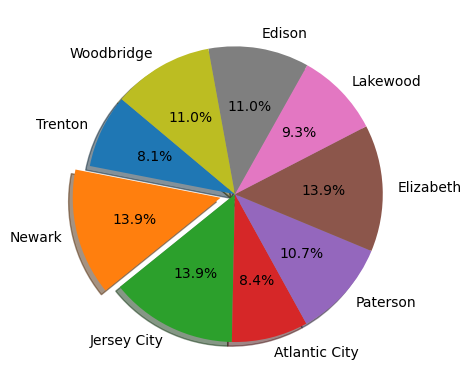

In [46]:
# Showing which cities have the highest concentration of CO in New Jersey. 
# Newark, Jersey City, and Elizabeth are all showing high concentrations of pollutants such as  CO, O3, PM2.5, and more 

Nj_df = usa_df.loc[usa_df["state"] == "New Jersey"]

labels = Nj_df["city"]
sizes = Nj_df["CO"]
explode = (0, 0.1, 0, 0, 0, 0, 0, 0, 0)

# Create pie chart based on above data
plt.pie(sizes, explode=explode, labels=labels, autopct="%1.1f%%", shadow=True, startangle=140)


# Save the figure
plt.savefig("output_data/Fig2.png")

# Show plot
plt.show()

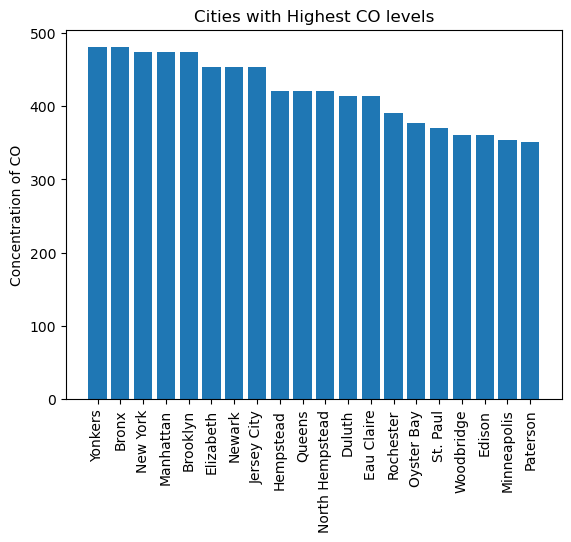

In [47]:
# We can see that the New York and New Jersey cities show very large Carbon Monoxide concentration levels during the day.
co_df = usa_df.sort_values(by="CO", ascending=False).head(20)

# Create bar chart showing cities with Highest concentration of Carbon Monoxide
plt.bar(co_df["city"], co_df["CO"])
plt.title("Cities with Highest CO levels")
plt.ylabel("Concentration of CO")
plt.xticks(rotation = 90)

# Save the figure
plt.savefig("output_data/Fig3.png")

# Show plot
plt.show()

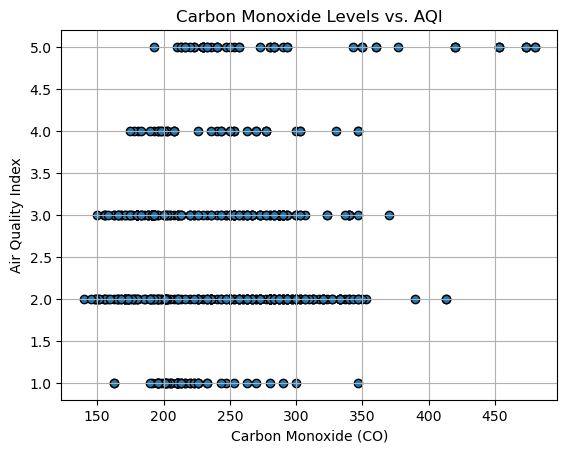

In [105]:
# Build scatter plot for 
x = usa_df["CO"]
y = usa_df["AQI"]

plt.scatter(x, y, edgecolors="black")

# Incorporate the other graph properties
plt.title("Carbon Monoxide Levels vs. AQI")
plt.xlabel("Carbon Monoxide (CO)")
plt.ylabel("Air Quality Index")

plt.grid()

# Save the figure
plt.savefig("output_data/Fig4.png")

# Show plot
plt.show()

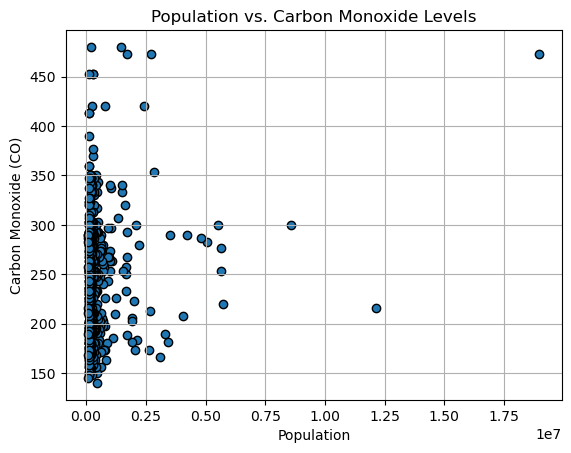

In [106]:
# Build scatter plot for 
x = usa_df["population"]
y = usa_df["CO"]

plt.scatter(x, y, edgecolors="black")

# Incorporate the other graph properties
plt.title("Population vs. Carbon Monoxide Levels")
plt.xlabel("Population")
plt.ylabel("Carbon Monoxide (CO)")

plt.grid()

# Save the figure
plt.savefig("output_data/Fig5.png")

# Show plot
plt.show()

In [43]:
%%capture --no-display

# Configure the map plot
map_plot_1 = usa_df.hvplot.points("lng", "lat",  geo = True, tiles = "OSM", color = "city",
                                  hover_cols = ["city", "state", "population", "AQI"], frame_width=700, frame_height=500)

# Display the map
map_plot_1


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lng,lat]   (city,state,population,AQI)

In [121]:
vehicle_df = pd.read_excel("Resources/US_Vehicle_Data.xlsx")

merged_df = pd.merge(usa_df, vehicle_df, how="left", on="state")

merged_df.head()

,city,city_ascii,lat,lng,country,iso2,iso3,state,capital,population,...,AQI,CO,NO,NO2,O3,SO2,PM2.5,PM10,NH3,vehicles
0,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,18972871,...,5,473.0,0.0,28.0,303.0,19.0,55.0,58.0,2.0,11324755
1,Los Angeles,Los Angeles,34.1141,-118.4068,United States,US,USA,California,NaN,12121244,...,5,216.0,0.0,2.0,194.0,3.0,17.0,23.0,0.0,30398249
2,Chicago,Chicago,41.8375,-87.6866,United States,US,USA,Illinois,NaN,8595181,...,3,300.0,0.0,4.0,110.0,2.0,5.0,5.0,0.0,10587725
3,Miami,Miami,25.7840,-80.2101,United States,US,USA,Florida,NaN,5711945,...,1,220.0,0.0,4.0,52.0,1.0,2.0,3.0,0.0,18464506
4,Dallas,Dallas,32.7935,-96.7667,United States,US,USA,Texas,NaN,5668165,...,4,277.0,0.0,3.0,164.0,1.0,7.0,8.0,0.0,22419490


In [122]:
# Define function for linear regression plot
def linRegressionPlots(x_values, y_values):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    
    plt.scatter(x_values,y_values)
    plt.plot(x_values,regress_values,"r-")
    plt.annotate(line_eq,(5.8,0.8),fontsize=15,color="red")
    print(f"The r-squared is: {rvalue**2}")

    correlation = st.pearsonr(x_values, y_values)
    print(f"The correlation between both factors is {round(correlation[0],2)}")

The r-squared is: 0.07757551808967399
The correlation between both factors is -0.28


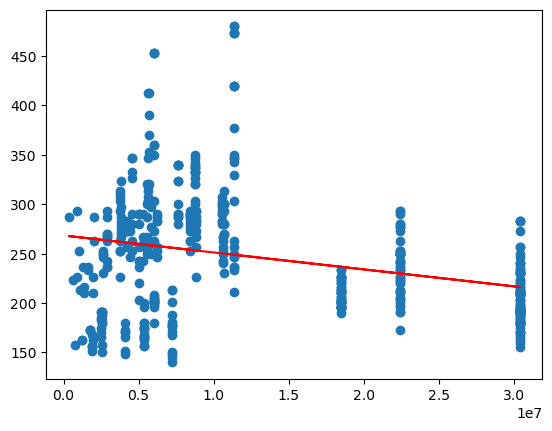

In [126]:
# Build scatter plot for 
vehicles = merged_df["vehicles"]
CO = merged_df["CO"]

# Trying to see if there is a correlation between registered vehicles and Carbon Monoxide pollution
linRegressionPlots(vehicles, CO)

# Show plot
plt.show()

In [261]:
# Getting the Air Pollution data for the past week in New York

datetime = []
aqi = []

base_url = "http://api.openweathermap.org/data/2.5/air_pollution/history?"

lat = 40.6943
lon = -73.9249

start = 1689648376
end = 1690253176

params = {"start":start, 
          "end": end,
          "lat": lat,
          "lon": lon,
          "appid":api_key}

    
response = requests.get(base_url, params=params)
data = response.json()


for date in data["list"]:    
    datetime.append(date["dt"])
    aqi.append(date["main"]["aqi"])

In [242]:
time_df = pd.DataFrame({"date": datetime, "AQI": aqi})

time_df

,date,AQI
0,1689649200,2
1,1689652800,2
2,1689656400,2
3,1689660000,2
4,1689663600,2
...,...,...
163,1690236000,2
164,1690239600,2
165,1690243200,2
166,1690246800,2


In [243]:
time_df["day"] = " "

In [246]:
from datetime import datetime

for index, row in time_df.iterrows():
    
    day = row["date"]
    date = pd.to_datetime(day, unit= 's')
    
    time_df.loc[index, "day"] = date
    
    
print(time_df)
    

           date  AQI                  day
0    1689649200    2  2023-07-18 03:00:00
1    1689652800    2  2023-07-18 04:00:00
2    1689656400    2  2023-07-18 05:00:00
3    1689660000    2  2023-07-18 06:00:00
4    1689663600    2  2023-07-18 07:00:00
..          ...  ...                  ...
163  1690236000    2  2023-07-24 22:00:00
164  1690239600    2  2023-07-24 23:00:00
165  1690243200    2  2023-07-25 00:00:00
166  1690246800    2  2023-07-25 01:00:00
167  1690250400    2  2023-07-25 02:00:00

[168 rows x 3 columns]


In [253]:
time_df = time_df[["day", "AQI"]]

time_df

,day,AQI
0,2023-07-18 03:00:00,2
1,2023-07-18 04:00:00,2
2,2023-07-18 05:00:00,2
3,2023-07-18 06:00:00,2
4,2023-07-18 07:00:00,2
...,...,...
163,2023-07-24 22:00:00,2
164,2023-07-24 23:00:00,2
165,2023-07-25 00:00:00,2
166,2023-07-25 01:00:00,2


In [254]:
time_df["day"] = time_df["day"].astype("datetime64[ms]")

In [256]:
time_df.dtypes

day    datetime64[ns]
AQI             int64
dtype: object

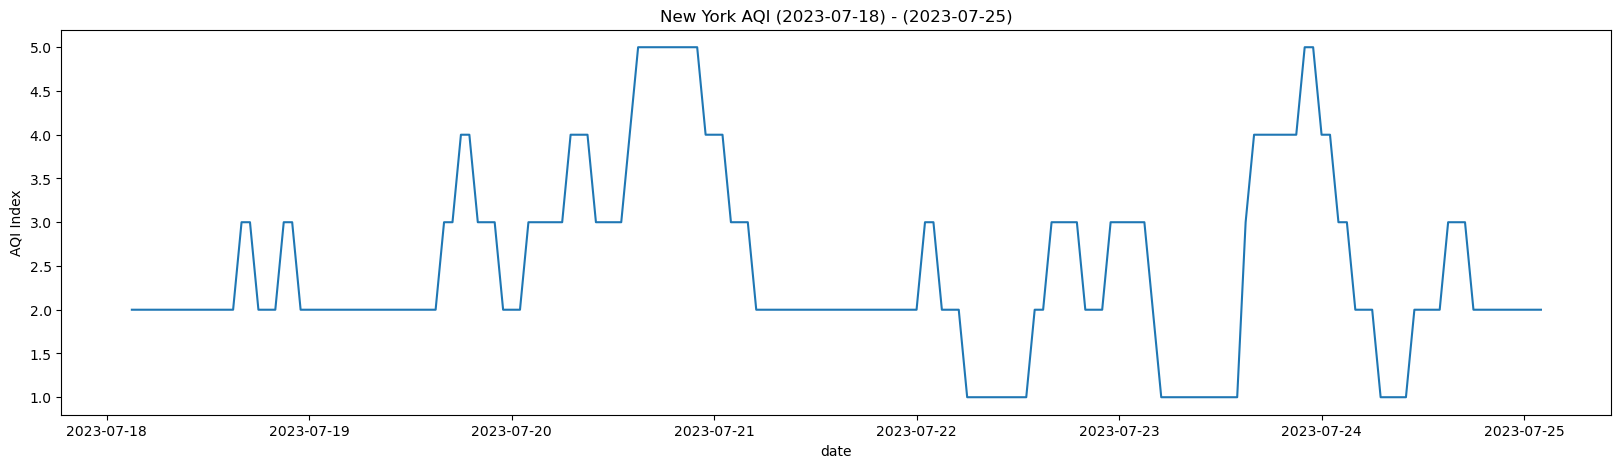

In [263]:
# Plot the linear graph for last week of New York's API index.
plt.figure(figsize=(20,5))
plt.plot(time_df["day"], time_df["AQI"])

# Set labels
plt.xlabel("date")
plt.ylabel("AQI Index")
plt.title("New York AQI (2023-07-18) - (2023-07-25)")

plt.show()